In [ ]:
#Synthetic data generation using Variational Autoencoder
#
# TEAM MEMBERS
# Deepesh Kumar Sahu cs23mtech11006
# Naveen Nayak cs23mtech11011
# Pramod Hembrom cs23mtech11015
# Sameer Atram cs23mtech11017


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
%cd /content/drive/My Drive

/content/drive/My Drive


In [35]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torch.optim import Adam

In [36]:
data_pd=pd.read_csv('card_transaction.v1.csv')

In [37]:
print(data_pd.columns)

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Is Fraud?'],
      dtype='object')


In [38]:
print(data_pd.iloc[11])

User                                  0
Card                                  0
Year                               2002
Month                                 9
Day                                   5
Time                              20:41
Amount                           $53.91
Use Chip             Online Transaction
Merchant Name    -9092677072201095168.0
Merchant City                    ONLINE
Merchant State                      NaN
Zip                                 NaN
MCC                              4900.0
Errors?                             NaN
Is Fraud?                            No
Name: 11, dtype: object


In [39]:
# Retrieve the list of columns in the dataset
columns_to_encode = list(data_pd.columns)

# Check if 'Amount' column exists and convert it to float if necessary
if 'Amount' in data_pd.columns:
    if data_pd['Amount'].dtype == 'object':
        # Convert the 'Amount' column to float after removing the dollar sign
        data_pd['Amount'] = data_pd['Amount'].str.replace('$', '').astype(float)

# Specify the columns to skip during encoding
columns_to_skip = {'Amount'}

# Initialize an empty dictionary to store label encoders
label_encoders = {}


In [40]:
from sklearn.preprocessing import LabelEncoder

def encode_columns(data_pd, columns_to_encode, columns_to_skip):
    label_encoders = {}
    for column in columns_to_encode:
        if column not in columns_to_skip:
            label_encoders[column] = LabelEncoder()
            data_pd[column + '_encoded'] = label_encoders[column].fit_transform(data_pd[column])
            data_pd.drop(columns=[column], inplace=True)
    return data_pd, label_encoders


In [41]:
encode_columns(data_pd,data_pd.columns,['Amount']);

In [42]:
# Replace NaN values with the median of the column
data_pd.fillna(data_pd.median(), inplace=True)

In [43]:
data_pd_normalized = (data_pd - data_pd.min()) / (data_pd.max() - data_pd.min())

In [44]:
print(data_pd_normalized.columns)

Index(['Amount', 'User_encoded', 'Card_encoded', 'Year_encoded',
       'Month_encoded', 'Day_encoded', 'Time_encoded', 'Use Chip_encoded',
       'Merchant Name_encoded', 'Merchant City_encoded',
       'Merchant State_encoded', 'Zip_encoded', 'MCC_encoded',
       'Errors?_encoded', 'Is Fraud?_encoded'],
      dtype='object')


In [45]:
print(data_pd_normalized.iloc[11])

Amount                    0.075669
User_encoded              0.000000
Card_encoded              0.000000
Year_encoded              0.280000
Month_encoded             0.727273
Day_encoded               0.133333
Time_encoded              0.862500
Use Chip_encoded          0.333333
Merchant Name_encoded     0.006822
Merchant City_encoded     0.000000
Merchant State_encoded    1.000000
Zip_encoded               1.000000
MCC_encoded               0.412844
Errors?_encoded           1.000000
Is Fraud?_encoded         0.000000
Name: 11, dtype: float64


In [46]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data_pd, transform=None):
        self.data = data_pd
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        features = torch.tensor(sample, dtype=torch.float32)
        if self.transform:
            features = self.transform(features)
        return features

    def get_sample(self, idx):
        return self.data.iloc[idx]

    def apply_transform(self, idx):
        sample = self.data.iloc[idx]
        features = torch.tensor(sample, dtype=torch.float32)
        if self.transform:
            features = self.transform(features)
        return features

    def preprocess_data(self):
        # You can add preprocessing steps here if needed
        pass


In [47]:
dataset = CustomDataset(data_pd_normalized)

# Create DataLoader to create batches of data
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [49]:
import torch
import torch.nn as nn

class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim=15, hidden_dim=10, latent_dim=8, device=device):
        super(VariationalAutoencoder, self).__init__()

        # Define device
        self.device = device

        # Encoder layers
        self.encoder = self._build_encoder(input_dim, hidden_dim, latent_dim)

        # Decoder layers
        self.decoder = self._build_decoder(latent_dim, hidden_dim, input_dim)

        self.latent_dim = latent_dim

    def _build_encoder(self, input_dim, hidden_dim, latent_dim):
        encoder_layers = [
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # Two times latent dimensions for mean and variance
        ]
        return nn.Sequential(*encoder_layers)

    def _build_decoder(self, latent_dim, hidden_dim, output_dim):
        decoder_layers = [
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU()
        ]
        return nn.Sequential(*decoder_layers)

    def encode(self, input_data):
        # Forward pass through encoder
        encoded_output = self.encoder(input_data)
        # Split encoded representation into mean and log-variance
        mean, logvar = torch.chunk(encoded_output, 2, dim=1)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        # Sample epsilon from standard normal distribution
        epsilon = torch.randn_like(mean).to(self.device)
        # Reparameterize to sample latent variable z
        return mean + torch.exp(0.5 * logvar) * epsilon

    def decode(self, sampled_latent):
        # Forward pass through decoder
        reconstructed_output = self.decoder(sampled_latent)
        return reconstructed_output

    def forward(self, input_data):
        # Encode input data into mean and log-variance
        mean, logvar = self.encode(input_data)
        # Sample latent variable z
        sampled_latent = self.reparameterization(mean, logvar)
        # Decode latent variable to reconstruct input data
        reconstructed_output = self.decode(sampled_latent)
        return reconstructed_output, mean, logvar


In [50]:
import torch.nn.functional as F

def reconstruction_loss(x, x_hat):
    # Compute mean squared error reconstruction loss
    return F.mse_loss(x_hat, x, reduction='sum')

def kld_loss(mean, log_var):
    # Compute Kullback-Leibler Divergence (KLD) loss
    return -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

def total_loss(x, x_hat, mean, log_var):
    # Combine reconstruction loss and KLD loss
    return reconstruction_loss(x, x_hat) + kld_loss(mean, log_var)


In [51]:
model = VariationalAutoencoder().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
epochs=10

In [32]:
model.train()

for e in range(epochs):
    t_loss = 0

    for idx, data in enumerate(dataloader):
        data = data.to(device)

        optimizer.zero_grad()

        reconstructed_data, mu, log_variance = model(data)
        current_loss = total_loss(data, reconstructed_data, mu, log_variance)

        current_loss.backward()
        optimizer.step()

        t_loss += current_loss.item()

    avg_loss = t_loss / len(dataloader.dataset)
    print(f"Epoch {e + 1}\tAverage Loss: {avg_loss:.4f}")


Epoch 1	Average Loss: 0.8932
Epoch 2	Average Loss: 0.8631
Epoch 3	Average Loss: 0.8631
Epoch 4	Average Loss: 0.8630
Epoch 5	Average Loss: 0.8630
Epoch 6	Average Loss: 0.8630
Epoch 7	Average Loss: 0.8629
Epoch 8	Average Loss: 0.8629
Epoch 9	Average Loss: 0.8629
Epoch 10	Average Loss: 0.8629


In [52]:
def create_synthetic_data(vae, sample_count, latent_dim):
    # Sample from the latent space (assume latent_dim is the size of the latent space)
    latent_space_samples = torch.randn(sample_count, latent_dim).to(device)

    # Decode the samples using the VAE decoder
    with torch.no_grad():
        synthetic_data = vae.decode(latent_space_samples)

    return synthetic_data

# Generate synthetic data
sample_count = 2000000
synthetic_data = create_synthetic_data(model, sample_count, 8)


In [55]:
synthetic_data_df = pd.DataFrame(synthetic_data.cpu().numpy())
synthetic_data_df.columns = data_pd.columns

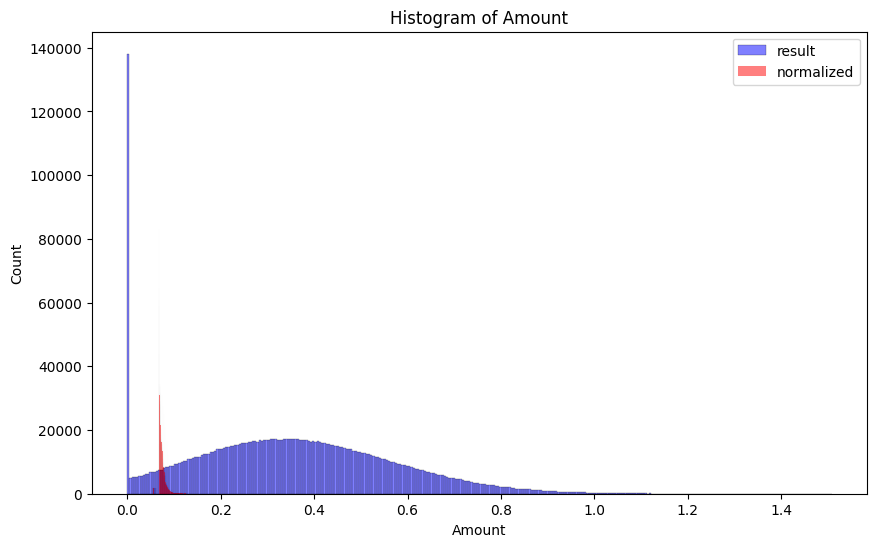

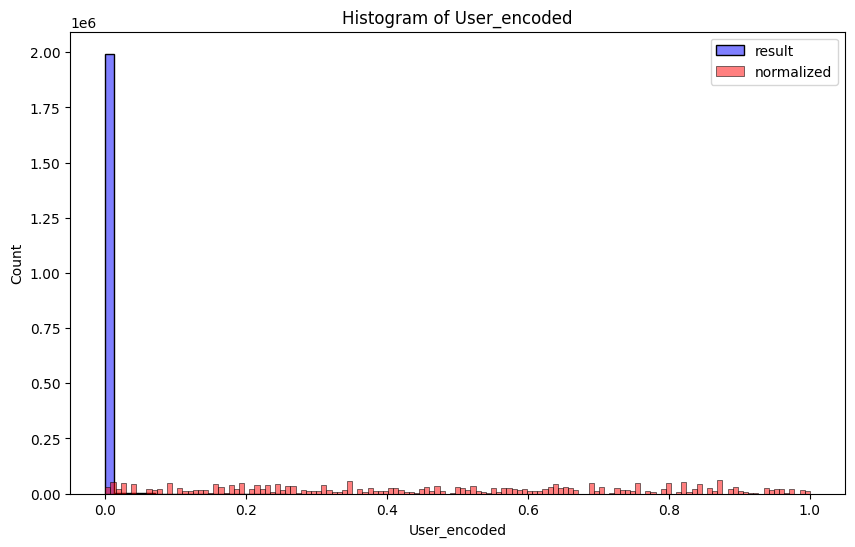

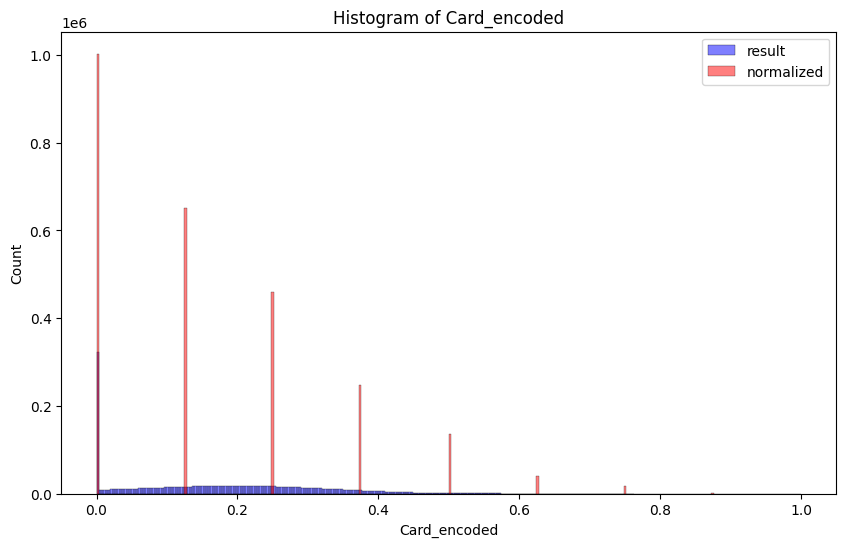

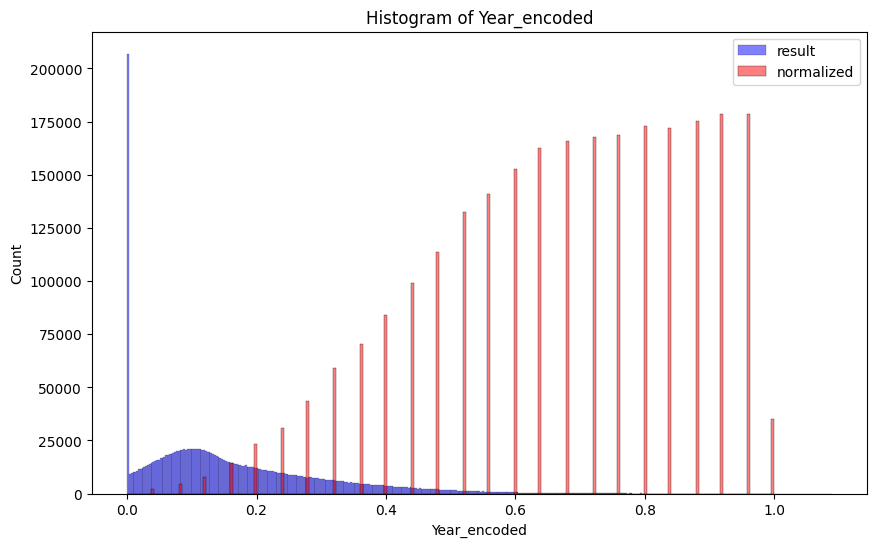

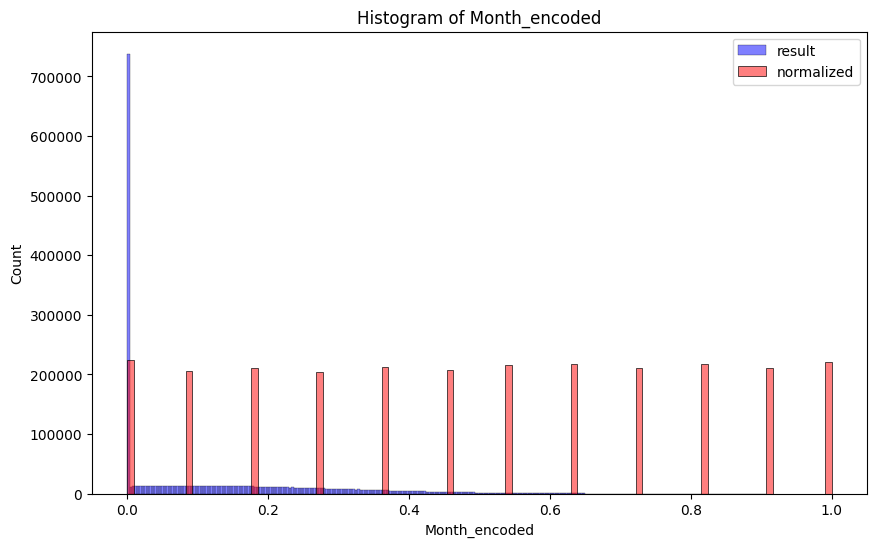

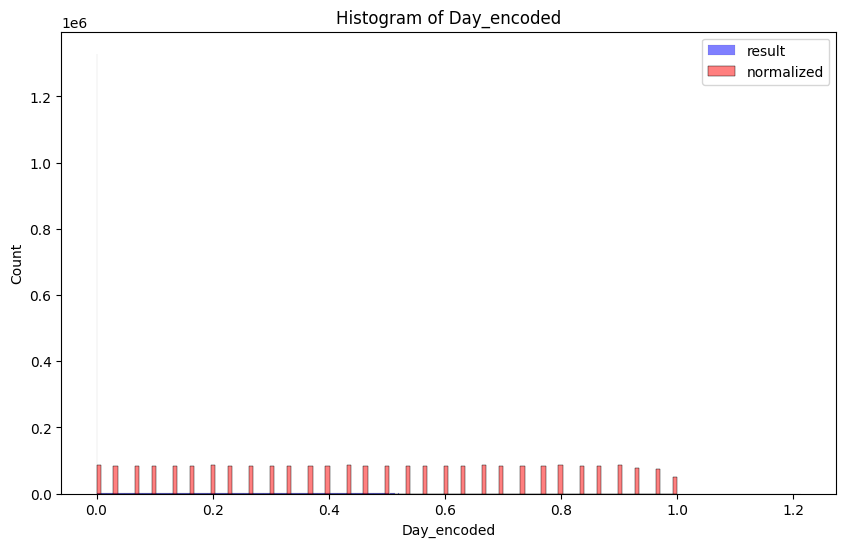

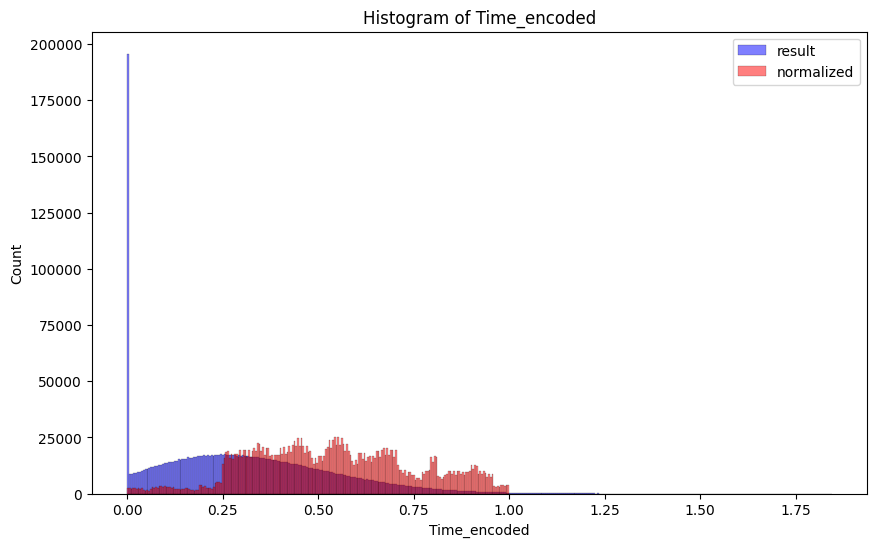

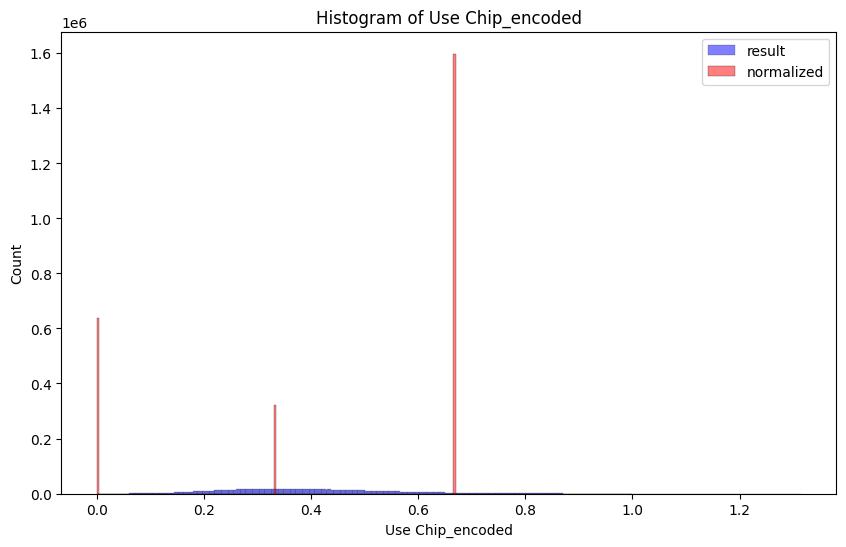

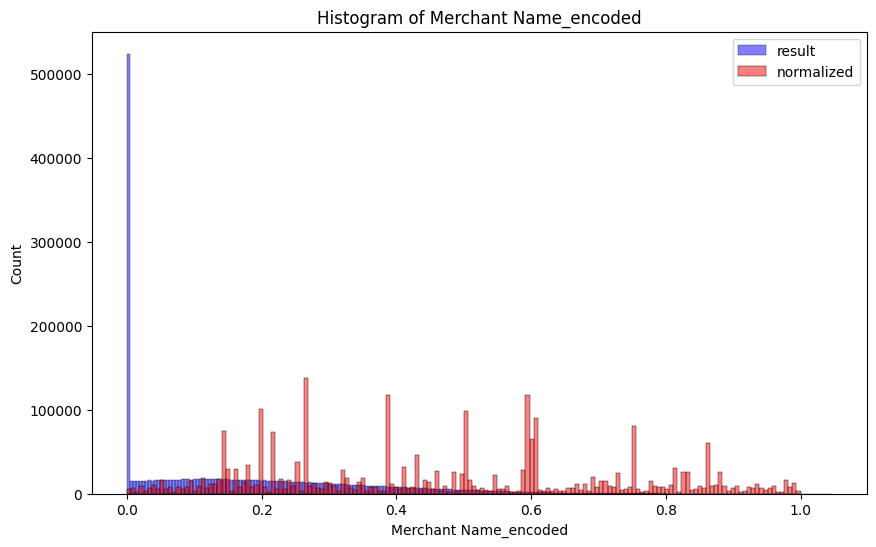

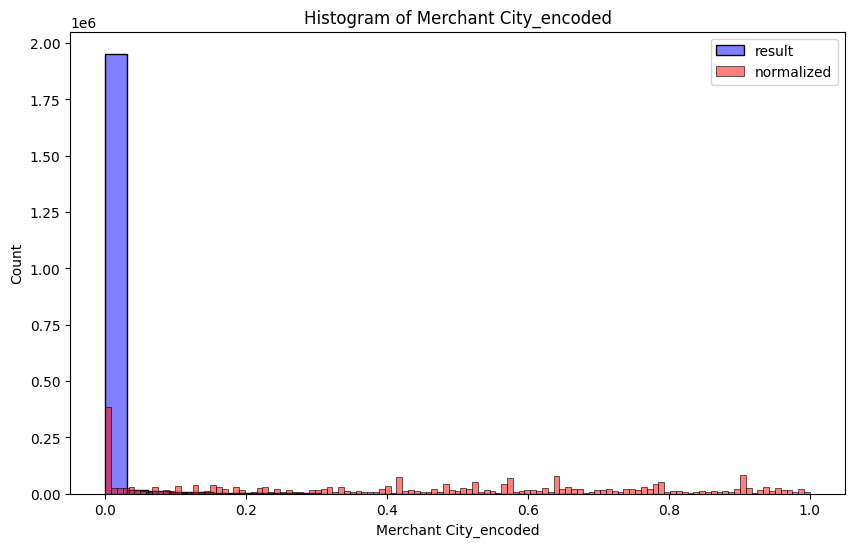

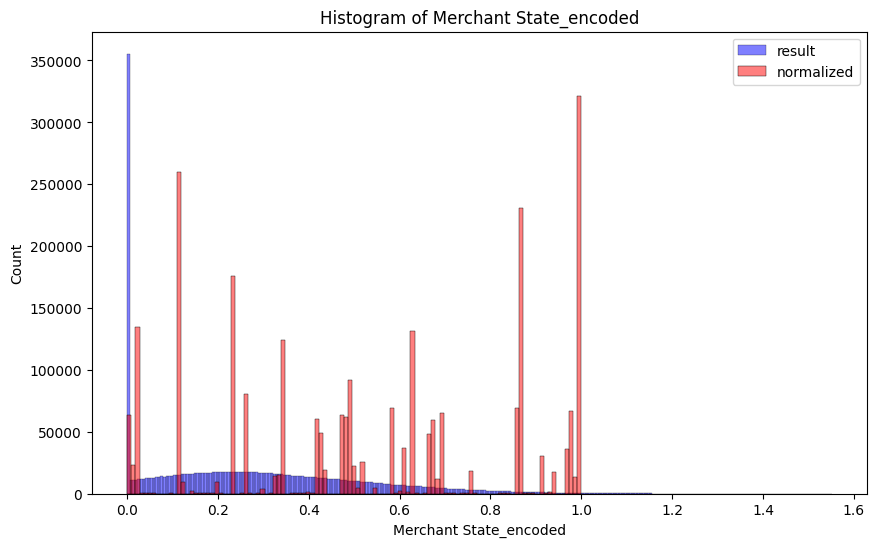

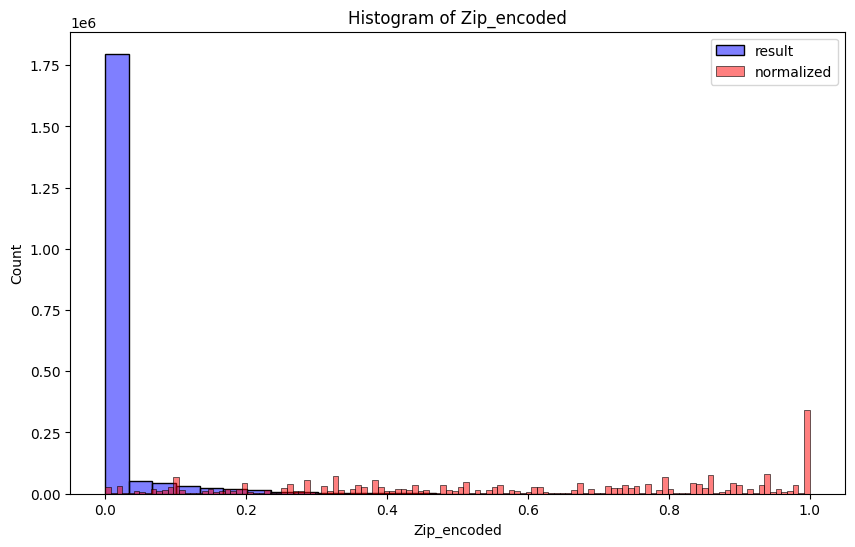

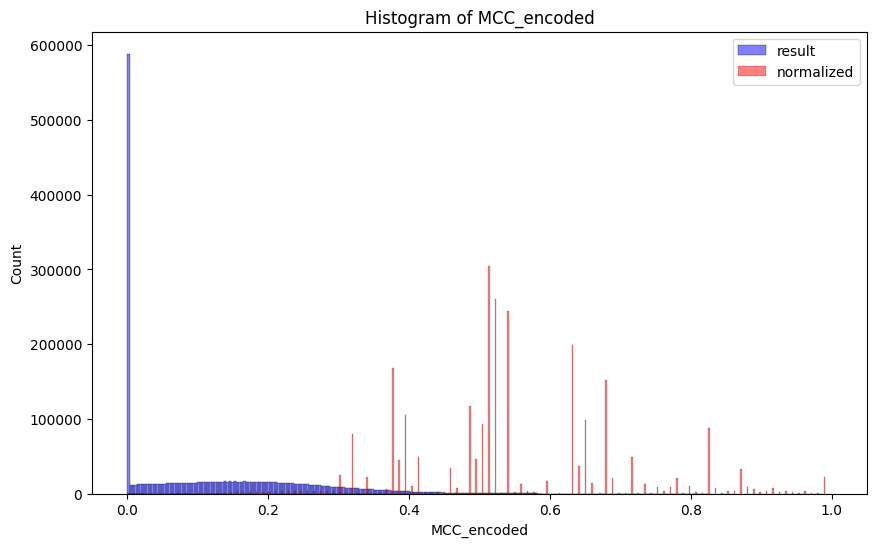

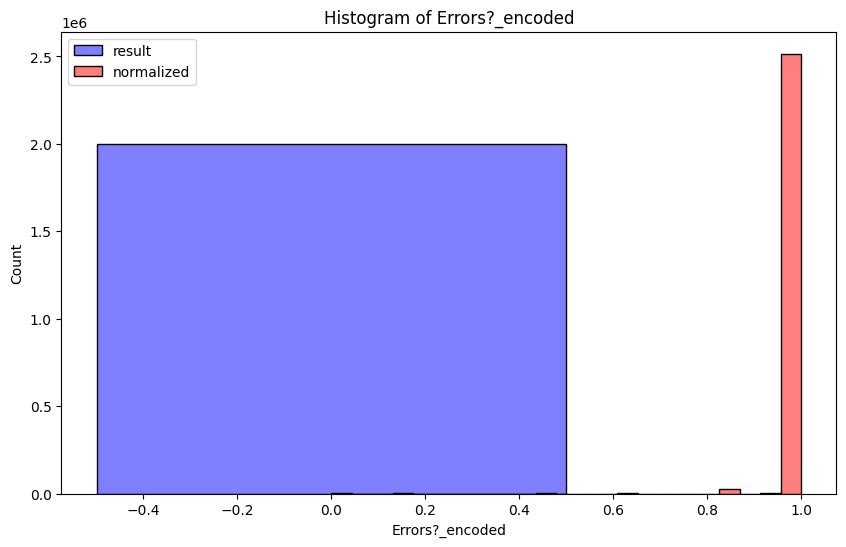

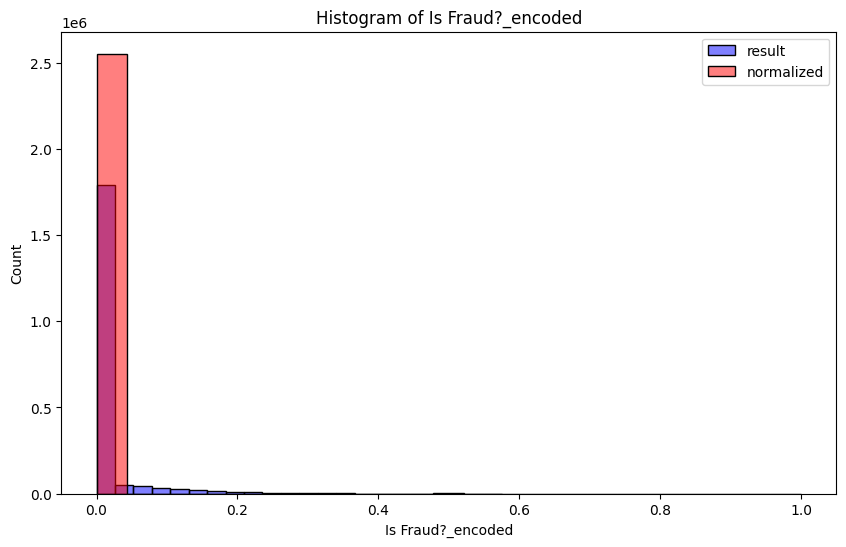

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histograms(result_df, normalized_df):
    numeric_columns = result_df.select_dtypes(include='number').columns

    for column in numeric_columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(result_df[column], color='blue', alpha=0.5, label='result')
        sns.histplot(normalized_df[column], color='red', alpha=0.5, label='normalized')
        plt.title(f'Histogram of {column}')
        plt.legend()
        plt.show()

# Usage
plot_histograms(synthetic_data_df, data_pd_normalized)


In [59]:
num_duplicates = synthetic_data_df.duplicated().sum()

print("Number of duplicate rows:", num_duplicates)

Number of duplicate rows: 0
